[*********************100%%**********************]  1 of 1 completed


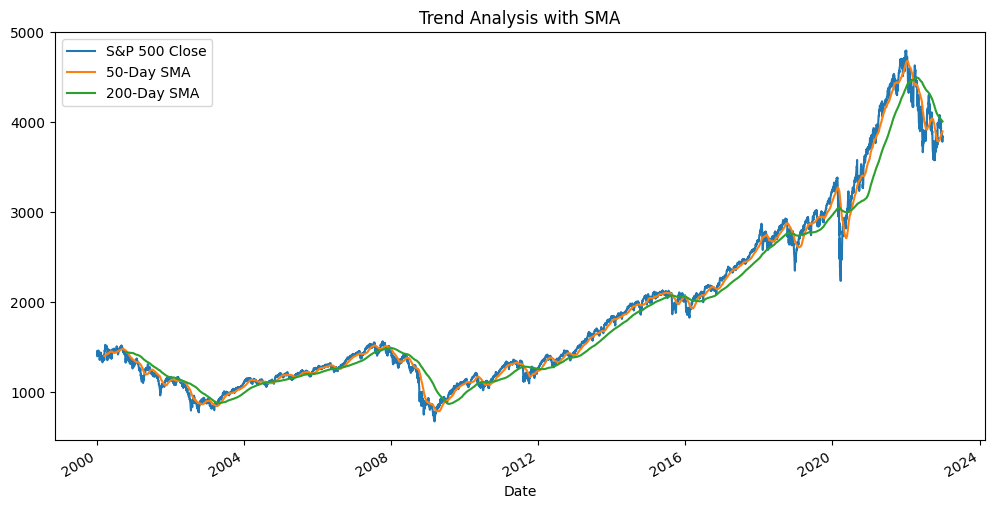

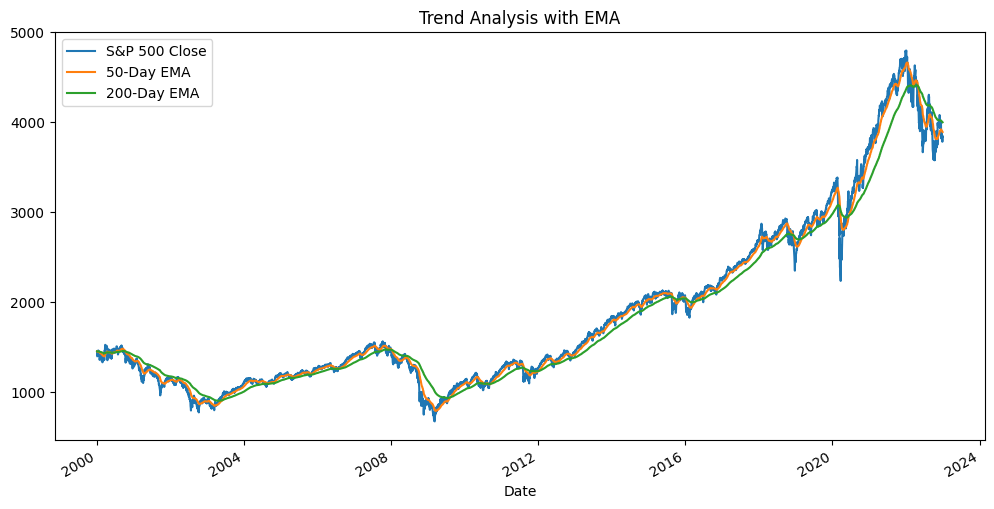

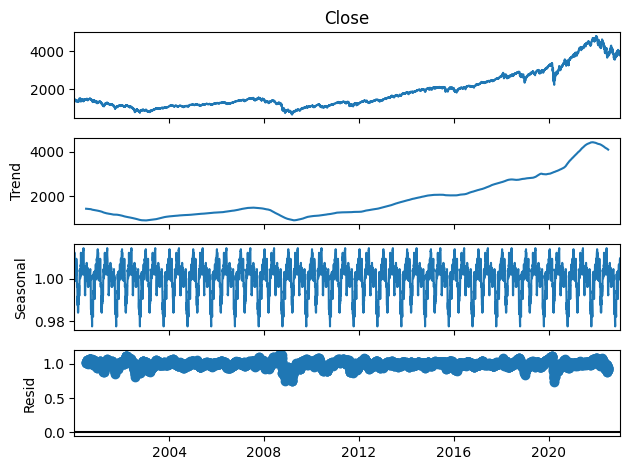

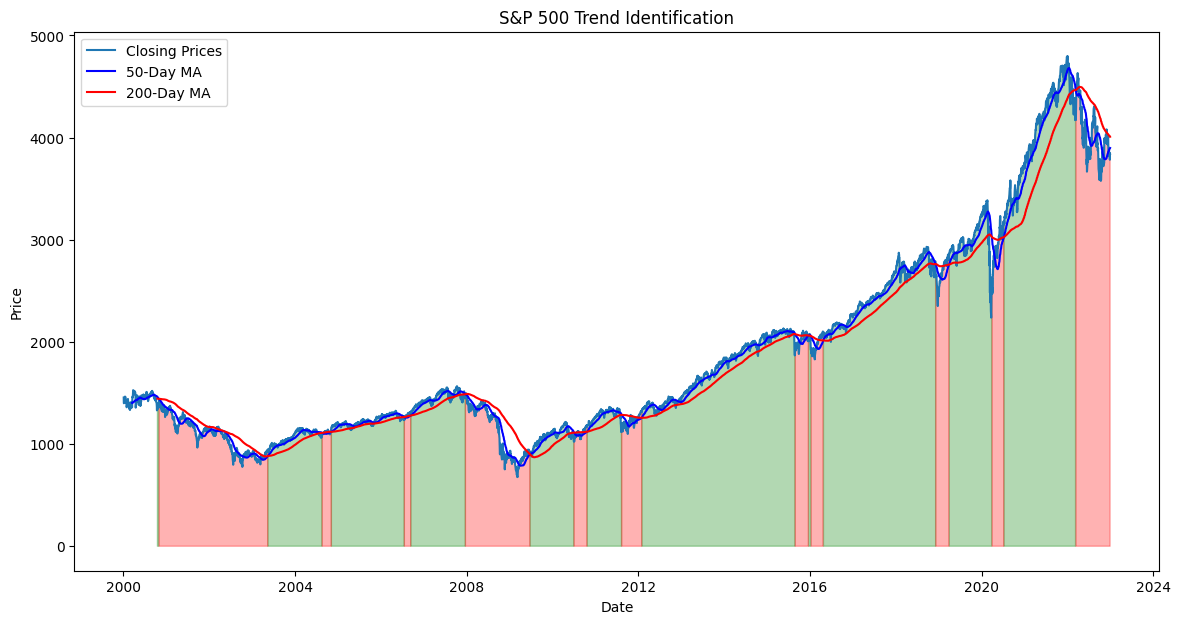

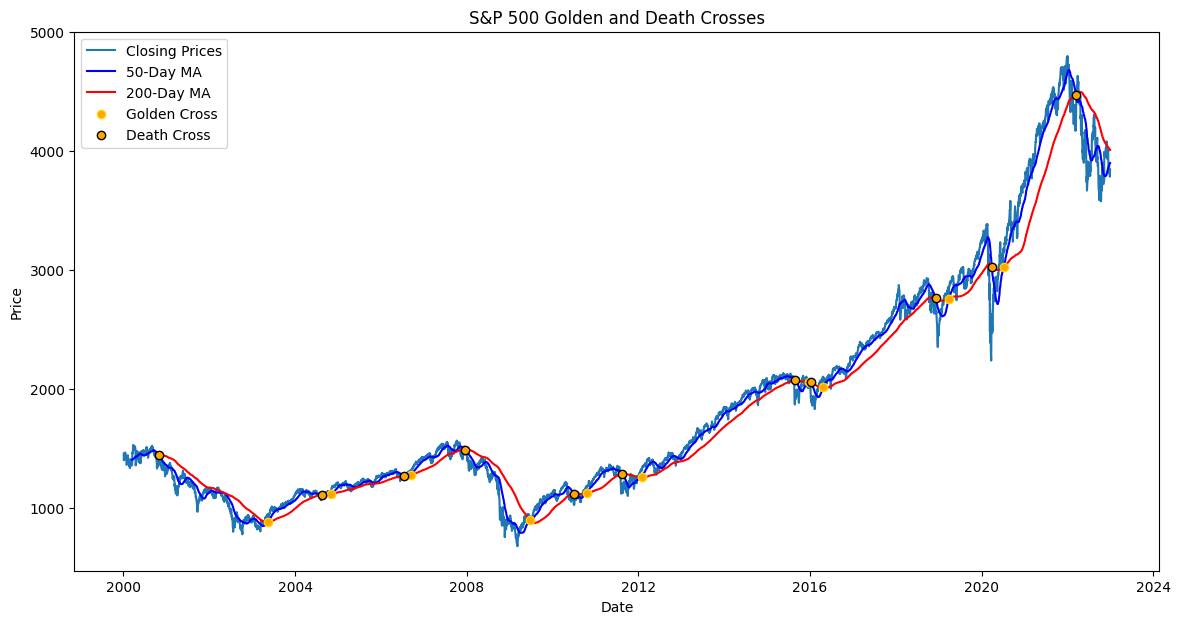

Statistics for periods above 50 EMA:
1. Maximum number of days: 136
2. Average number of days: 21.86
3. Median number of days: 11.0
4. Minimum % change: 0.14%
5. Maximum % change: 26.19%
6. Median % change: 2.76%
7. Average % change: 4.42%
----------------------------------------
Statistics for periods below 50 EMA:
1. Maximum number of days: 86
2. Average number of days: 12.77
3. Median number of days: 5.0
4. Minimum % change: -0.16%
5. Maximum % change: -41.63%
6. Median % change: -2.58%
7. Average % change: -4.55%
----------------------------------------
Statistics for periods above 200 EMA:
1. Maximum number of days: 477
2. Average number of days: 53.53
3. Median number of days: 6.0
4. Minimum % change: 0.14%
5. Maximum % change: 63.10%
6. Median % change: 2.39%
7. Average % change: 6.80%
----------------------------------------
Statistics for periods below 200 EMA:
1. Maximum number of days: 274
2. Average number of days: 25.31
3. Median number of days: 5.5
4. Minimum % change: -0

In [5]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

# Retrieve S&P 500 data
sp500_data = yf.download('^GSPC', start='2000-01-01', end='2023-01-01')

# Let's focus on the 'Close' column for trend analysis
closing_prices = sp500_data['Close']

# Calculate the 50-day and 200-day SMAs
sma50 = closing_prices.rolling(window=50).mean()
sma200 = closing_prices.rolling(window=200).mean()

# Plotting
plt.figure(figsize=(12,6))
closing_prices.plot(label='S&P 500 Close')
sma50.plot(label='50-Day SMA')
sma200.plot(label='200-Day SMA')
plt.legend()
plt.title('Trend Analysis with SMA')
plt.show()

# Calculate the 50-day and 200-day EMAs
ema50 = closing_prices.ewm(span=50, adjust=False).mean()
ema200 = closing_prices.ewm(span=200, adjust=False).mean()

# Plotting
plt.figure(figsize=(12,6))
closing_prices.plot(label='S&P 500 Close')
ema50.plot(label='50-Day EMA')
ema200.plot(label='200-Day EMA')
plt.legend()
plt.title('Trend Analysis with EMA')
plt.show()

# Decompose to retrieve trend, seasonal, and residual components
result = seasonal_decompose(closing_prices, model='multiplicative', period=252)
result.plot()
plt.show()

################################################################################
# Trend identification:

# Using the same DataFrame 'sp500_data' for the trend identification
# Calculate the 50-day and 200-day moving averages
sp500_data['50_MA'] = closing_prices.rolling(window=50).mean()
sp500_data['200_MA'] = closing_prices.rolling(window=200).mean()

# Plotting Trend Identification
plt.figure(figsize=(14,7))
plt.plot(sp500_data['Close'], label='Closing Prices')
plt.plot(sp500_data['50_MA'], label='50-Day MA', color='blue')
plt.plot(sp500_data['200_MA'], label='200-Day MA', color='red')

# Highlighting bullish or bearish zones
sp500_data['Bullish'] = np.where(sp500_data['50_MA'] > sp500_data['200_MA'], sp500_data['Close'], np.nan)
sp500_data['Bearish'] = np.where(sp500_data['50_MA'] < sp500_data['200_MA'], sp500_data['Close'], np.nan)

plt.fill_between(sp500_data.index, sp500_data['Bullish'], color='green', alpha=0.3)
plt.fill_between(sp500_data.index, sp500_data['Bearish'], color='red', alpha=0.3)

plt.title('S&P 500 Trend Identification')
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend(loc='best')
plt.show()

# Golden and Death Crosses Plot
plt.figure(figsize=(14,7))
plt.plot(sp500_data['Close'], label='Closing Prices')
plt.plot(sp500_data['50_MA'], label='50-Day MA', color='blue')
plt.plot(sp500_data['200_MA'], label='200-Day MA', color='red')

# Identify golden cross and death cross
golden_crosses = ((sp500_data['50_MA'] > sp500_data['200_MA']) & (sp500_data['50_MA'].shift(1) <= sp500_data['200_MA'].shift(1)))
death_crosses = ((sp500_data['50_MA'] < sp500_data['200_MA']) & (sp500_data['50_MA'].shift(1) >= sp500_data['200_MA'].shift(1)))

# Mark golden crosses and death crosses with orange circles
plt.scatter(sp500_data[golden_crosses].index, sp500_data['200_MA'][golden_crosses], color='orange', edgecolors='gold', label='Golden Cross', zorder=5)
plt.scatter(sp500_data[death_crosses].index, sp500_data['200_MA'][death_crosses], color='orange', edgecolors='black', label='Death Cross', zorder=5)

plt.title('S&P 500 Golden and Death Crosses')
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend(loc='best')
plt.show()

###########################################################################################
#statistics:

def compute_statistics(closing_prices, moving_avg, condition="above"):
    if condition == "above":
        periods = (closing_prices > moving_avg).astype(int)
    else:
        periods = (closing_prices < moving_avg).astype(int)
    
    periods = (periods != periods.shift()).cumsum() * periods
    periods = periods[periods != 0]
    days_counts = periods.value_counts()
    days_counts = days_counts[days_counts > 1]

    max_days = days_counts.max()
    avg_days = days_counts.mean()
    median_days = days_counts.median()

    percent_changes = []
    for period_num, days_count in days_counts.items():
        start_date = periods[periods == period_num].index[0]
        end_date = periods[periods == period_num].index[-1]

        start_value = moving_avg[start_date]
        if condition == "above":
            max_price_during_period = closing_prices[start_date:end_date].max()
        else:
            max_price_during_period = closing_prices[start_date:end_date].min()

        percent_change = ((max_price_during_period - start_value) / start_value) * 100
        percent_changes.append(percent_change)

    if condition == "below":
        min_percent_change, max_percent_change = max(percent_changes), min(percent_changes)
    else:
        min_percent_change, max_percent_change = min(percent_changes), max(percent_changes)

    avg_percent_change = sum(percent_changes) / len(percent_changes)
    median_percent_change = sorted(percent_changes)[len(percent_changes) // 2]

    return max_days, avg_days, median_days, min_percent_change, max_percent_change, median_percent_change, avg_percent_change

conditions = {
    "above 50 EMA": ema50,
    "below 50 EMA": ema50,
    "above 200 EMA": ema200,
    "below 200 EMA": ema200,
    "above 50 SMA": sma50,
    "below 50 SMA": sma50,
    "above 200 SMA": sma200,
    "below 200 SMA": sma200
}

for condition_name, moving_avg in conditions.items():
    if "above" in condition_name:
        cond = "above"
    else:
        cond = "below"
    max_days, avg_days, median_days, min_percent_change, max_percent_change, median_percent_change, avg_percent_change = compute_statistics(closing_prices, moving_avg, cond)

    print(f"Statistics for periods {condition_name}:")
    print(f"1. Maximum number of days: {max_days}")
    print(f"2. Average number of days: {avg_days:.2f}")
    print(f"3. Median number of days: {median_days}")
    print(f"4. Minimum % change: {min_percent_change:.2f}%")
    print(f"5. Maximum % change: {max_percent_change:.2f}%")
    print(f"6. Median % change: {median_percent_change:.2f}%")
    print(f"7. Average % change: {avg_percent_change:.2f}%")
    print("-"*40)



######################################
# golden cross and death cross

def compute_cross_statistics(prices, ma50, ma200, cross_type="golden"):
    golden_crosses = ((ma50 > ma200) & (ma50.shift(1) <= ma200.shift(1)))
    death_crosses = ((ma50 < ma200) & (ma50.shift(1) >= ma200.shift(1)))

    if cross_type == "golden":
        cross_dates = prices[golden_crosses].index
    elif cross_type == "death":
        cross_dates = prices[death_crosses].index

    all_cross_dates = prices[golden_crosses | death_crosses].index

    durations = []
    percent_changes = []
    opposite_changes = []

    for idx, start_date in enumerate(cross_dates[:-1]):
        end_date = all_cross_dates[all_cross_dates.get_loc(start_date) + 1]
        start_price = prices[start_date]

        if cross_type == "golden":
            max_price_during_period = prices[start_date:end_date].max()
            declines = [(start_price - price) / start_price * 100 for price in prices[start_date:end_date]]
            max_decline = min(declines)
            opposite_changes.append(max_decline)
        else:  # death cross
            max_price_during_period = prices[start_date:end_date].min()
            gains = [(price - start_price) / start_price * 100 for price in prices[start_date:end_date]]
            max_gain = max(gains)
            opposite_changes.append(max_gain)

        duration = (prices[start_date:end_date].index[-1] - start_date).days
        percent_change = ((max_price_during_period - start_price) / start_price) * 100

        durations.append(duration)
        percent_changes.append(percent_change)

    max_duration = max(durations)
    avg_duration = sum(durations) / len(durations)
    median_duration = sorted(durations)[len(durations) // 2]
    min_percent_change = min(percent_changes)
    max_percent_change = max(percent_changes)
    avg_percent_change = sum(percent_changes) / len(percent_changes)
    median_percent_change = sorted(percent_changes)[len(percent_changes) // 2]
    
    max_opposite_change = max(opposite_changes)

    return max_duration, avg_duration, median_duration, min_percent_change, max_percent_change, median_percent_change, avg_percent_change, max_opposite_change




# For Golden Crosses
max_duration, avg_duration, median_duration, min_percent_change, max_percent_change, median_percent_change, avg_percent_change, max_opposite_change = compute_cross_statistics(sp500_data['Close'], sp500_data['50_MA'], sp500_data['200_MA'], "golden")

print("Statistics for Golden Crosses:")
print(f"1. Maximum duration between a Golden Cross and next Cross (Golden/Death): {max_duration} days")
print(f"2. Average duration between a Golden Cross and next Cross (Golden/Death): {avg_duration:.2f} days")
print(f"3. Median duration between a Golden Cross and next Cross (Golden/Death): {median_duration} days")
print(f"4. Minimum % change between a Golden Cross and peak price before next Cross: {min_percent_change:.2f}%")
print(f"5. Maximum % change between a Golden Cross and peak price before next Cross: {max_percent_change:.2f}%")
print(f"6. Median % change between a Golden Cross and peak price before next Cross: {median_percent_change:.2f}%")
print(f"7. Average % change between a Golden Cross and peak price before next Cross: {avg_percent_change:.2f}%")
print(f"8. Maximum % decline after a Golden Cross before the next Cross: {max_opposite_change:.2f}%")
print("-"*40)

# For Death Crosses
max_duration, avg_duration, median_duration, min_percent_change, max_percent_change, median_percent_change, avg_percent_change, max_opposite_change = compute_cross_statistics(sp500_data['Close'], sp500_data['50_MA'], sp500_data['200_MA'], "death")

print("Statistics for Death Crosses:")
print(f"1. Maximum duration between a Death Cross and next Cross (Golden/Death): {max_duration} days")
print(f"2. Average duration between a Death Cross and next Cross (Golden/Death): {avg_duration:.2f} days")
print(f"3. Median duration between a Death Cross and next Cross (Golden/Death): {median_duration} days")
print(f"4. Maximum % decline between a Death Cross and minimum price before next Cross: {min_percent_change:.2f}%")
print(f"5. Minimum % decline between a Death Cross and minimum price before next Cross: {max_percent_change:.2f}%")
print(f"6. Median % decline between a Death Cross and minimum price before next Cross: {median_percent_change:.2f}%")
print(f"7. Average % decline between a Death Cross and minimum price before next Cross: {avg_percent_change:.2f}%")
print(f"8. Maximum % gain after a Death Cross before the next Cross: {max_opposite_change:.2f}%")
print("-"*40)

#####################################################################################################
#checking the lagging of golden cross and death cross:

def max_percent_changes_before_crosses(prices, ma50, ma200):
    golden_crosses = ((ma50 > ma200) & (ma50.shift(1) <= ma200.shift(1)))
    death_crosses = ((ma50 < ma200) & (ma50.shift(1) >= ma200.shift(1)))

    golden_cross_dates = prices[golden_crosses].index
    death_cross_dates = prices[death_crosses].index

    max_gain_before_golden = []
    max_loss_before_death = []

    for date in golden_cross_dates:
        month_before = date - pd.Timedelta(days=50)
        max_price = prices[month_before:date].max()
        min_price = prices[month_before:date].min()
        
        percent_gain = ((max_price - min_price) / min_price) * 100
        max_gain_before_golden.append(percent_gain)

    for date in death_cross_dates:
        month_before = date - pd.Timedelta(days=50)
        max_price = prices[month_before:date].max()
        min_price = prices[month_before:date].min()

        percent_loss = ((min_price - max_price) / max_price) * 100
        max_loss_before_death.append(percent_loss)

    return max(max_gain_before_golden), max(max_loss_before_death)

max_gain_golden, max_loss_death = max_percent_changes_before_crosses(sp500_data['Close'], sp500_data['50_MA'], sp500_data['200_MA'])
print("checking the lagging:")
print(f"Maximum % gain before golden crosses: {max_gain_golden:.2f}%")
print(f"Maximum % loss before death crosses: {max_loss_death:.2f}%")

